![image](/Users/ishikaghosh/Library/CloudStorage/OneDrive-MichiganStateUniversity/Documents/Research/Projects/Interleaving_to_ML/ceREEBerus/doc_source/images/diagram_pictures/Diagram_1.png)

In [90]:
from cereeberus import ReebGraph, MapperGraph, Interleave
import cereeberus.data.ex_mappergraphs as ex_mg

import matplotlib.pyplot as plt
import numpy as np

import pulp #for ILP optimization

Text(0.5, 1.0, 'M2')

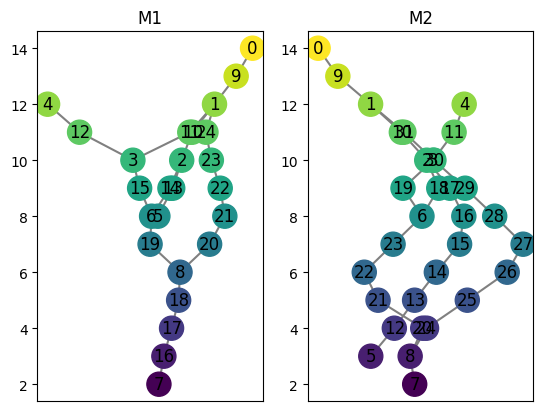

In [91]:
# Load example MapperGraphs

M1 = ex_mg.interleave_example_A()
M2 = ex_mg.interleave_example_B()
# M1 = ex_mg.torus(0, 2, 10, 12, delta = 1, seed = 17)
# M2 = ex_mg.line(0, 12)
plt.figure()
plt.subplot(121)
M1.draw()
plt.title('M1')
plt.subplot(122)
M2.draw()
plt.title('M2')

In [92]:
# create the interleaving
myInt = Interleave(M1, M2, initialize_random_maps=True, seed=10)

In [93]:
# set M1 as F and M2 as G for ease of notation
F = M1
G = M2

In [94]:
# get all the function values 

all_func_values = set(F.get_function_values()) | set(G.get_function_values())
print(all_func_values)

{2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14}


In [95]:
# get all the relevant matrices

# distance matrices
D_GnV = myInt.D('G','n','V')

# initial phi and psi maps
Phi_0V = myInt.phi('0','V')
Phi_0E = myInt.phi('0','E')

# boundary matrices
B_F0_up = myInt.B_up('F', '0')
B_Gn_up = myInt.B_up('G', 'n')


# ILPs: Right now we have individual ILPs for each diagrams. Need to figure out how to combine them into one ILP.

## A function to provide the necessary matrices upon request

In [110]:
def set_block_matrices(iter, starting_map, diagram_type, obj_type="vert", up_or_down="down"):
    """
    This function sets the block matrices required for the individual block optimization problems

    Parameters
    iter: int
        The function value for which the block matrices are to be set
    
    starting_map: str
        The starting map for the block matrices
        Options are:
        - 'F'
        - 'G'

    diagram_type: str
        The type of diagram for which the block matrices are needed. 
        Options are:
        - 'edge_vert_parallelogram': Liz's list 1, 2
        - 'parallelogram': Liz's list 3, 4, 5, 6
        - 'triangle': Liz's list 7, 8, 9, 10
    
    obj_type: str
        Wthether the diagram involves an edge or a vertex. Default is 'vert'
        Options are:
        - 'edge'
        - 'vert'
      
    
    up_or_down: str
        The direction of the boundary matrix. This changes some of the indexing. Default is 'down'
        Options are:
        - 'up'
        - 'down'
    
    Returns
    matrix_dict: dict
        A dictionary containing the block matrices
    """

    # Distance matrices
    D = {
    # vert
    'D_F0V': myInt.D('F', '0', 'V'),
    'D_FnV': myInt.D('F', 'n', 'V'),
    'D_F2nV': myInt.D('F', '2n', 'V'),
    'D_G0V': myInt.D('G', '0', 'V'),
    'D_GnV': myInt.D('G', 'n', 'V'),
    'D_G2nV': myInt.D('G', '2n', 'V'),

    # edge
    'D_F0E': myInt.D('F', '0', 'E'),
    'D_FnE': myInt.D('F', 'n', 'E'),
    'D_F2nE': myInt.D('F', '2n', 'E'),
    'D_G0E': myInt.D('G', '0', 'E'),
    'D_GnE': myInt.D('G', 'n', 'E'),
    'D_G2nE': myInt.D('G', '2n', 'E')}

    # Inclusion matrices
    I = {
    # vert
    'I_F0V': myInt.I('F','0','V'),
    'I_FnV': myInt.I('F','n','V'),
    'I_G0V': myInt.I('G','0','V'),
    'I_GnV': myInt.I('G','n','V'),

    # edge
    'I_F0E': myInt.I('F','0','E'),
    'I_FnE': myInt.I('F','n','E'),
    'I_G0E': myInt.I('G','0','E'),
    'I_GnE': myInt.I('G','n','E')}
    

    # Boundary matrices
    #up
    B_up = {
    'B_F0_up': myInt.B_up('F', '0'),
    'B_Fn_up': myInt.B_up('F', 'n'),
    'B_F2n_up': myInt.B_up('F', '2n'),
    'B_G0_up': myInt.B_up('G', '0'),
    'B_Gn_up': myInt.B_up('G', 'n'),
    'B_G2n_up': myInt.B_up('G', '2n')
    }

    #down
    B_down = {
    'B_F0_down': myInt.B_down('F', '0'),
    'B_Fn_down': myInt.B_down('F', 'n'),
    'B_F2n_down': myInt.B_down('F', '2n'),
    'B_G0_down': myInt.B_down('G', '0'),
    'B_Gn_down': myInt.B_down('G', 'n'),
    'B_G2n_down': myInt.B_down('G', '2n')
    }

    # Initial maps
    # phi
    Phi = {
    'Phi_0V': myInt.phi('0','V'),
    'Phi_nV': myInt.phi('n','V'),
    'Phi_0E': myInt.phi('0','E'),
    'Phi_nE': myInt.phi('n','E')
    }
    # psi
    Psi = {
    'Psi_0V': myInt.psi('0','V'),
    'Psi_nV': myInt.psi('n','V'),
    'Psi_0E': myInt.psi('0','E'),
    'Psi_nE': myInt.psi('n','E')
    }
    # Decide which diagram and return the appropriate matrices

    if diagram_type == 'edge_vert_parallelogram':
        # edge_vert_parallelogram ==> 1,2
        if starting_map == 'F':
            if up_or_down == 'up':
                matrix_dict = {'d':D['D_GnV'][iter+1].get_array(), 
                               'map_V':Phi['Phi_0V'][iter+1].get_array(), 
                               'map_E':Phi['Phi_0E'][iter].get_array(), 
                               'b_0': B_up['B_F0_up'][iter].get_array(), 
                               'b_n': B_up['B_Gn_up'][iter].get_array()}
                return matrix_dict
            if up_or_down == 'down':
                matrix_dict = {'d':D['D_GnV'][iter].get_array(),
                               'map_V':Phi['Phi_0V'][iter].get_array(),
                               'map_E':Phi['Phi_0E'][iter].get_array(),
                               'b_0': B_down['B_F0_down'][iter].get_array(),
                               'b_n': B_down['B_Gn_down'][iter].get_array()}
                return matrix_dict
            else:
                raise ValueError('Invalid value for up_or_down')
        if starting_map == 'G':
            if up_or_down == 'up':
                matrix_dict = {'d':D['D_FnV'][iter+1].get_array(),
                               'map_V':Psi['Psi_0V'][iter+1].get_array(),
                                'map_E':Psi['Psi_0E'][iter].get_array(),
                                'b_0': B_up['B_G0_up'][iter].get_array(),
                                'b_n': B_up['B_Fn_up'][iter].get_array()}
                return matrix_dict
            if up_or_down == 'down':
                matrix_dict = {'d':D['D_FnV'][iter].get_array(),
                               'map_V':Psi['Psi_0V'][iter].get_array(),
                               'map_E':Psi['Psi_0E'][iter].get_array(),
                               'b_0': B_down['B_G0_down'][iter].get_array(),
                               'b_n': B_down['B_Fn_down'][iter].get_array()}
                return matrix_dict
            else:
                raise ValueError('Invalid value for up_or_down')
        else:
            raise ValueError('Invalid value for starting_map')
    if diagram_type == 'parallelogram':
        if starting_map == 'F':
            if obj_type == 'vert': #==>  3
                matrix_dict = {'d':D['D_G2nV'][iter].get_array(),
                                'map_0':Phi['Phi_0V'][iter].get_array(),
                                'map_n':Phi['Phi_nV'][iter].get_array(),
                                'i_0': I['I_F0V'][iter].get_array(),
                                'i_n': I['I_GnV'][iter].get_array()}
                return matrix_dict
            if obj_type == 'edge': #==> 4
                matrix_dict = {'d':D['D_G2nE'][iter].get_array(),
                                'map_0':Phi['Phi_0E'][iter].get_array(),
                                'map_n':Phi['Phi_nE'][iter].get_array(),
                                'i_0': I['I_F0E'][iter].get_array(),
                                'i_n': I['I_GnE'][iter].get_array()}
                return matrix_dict
            else:   
                raise ValueError('Invalid value for obj_type')
        if starting_map == 'G':
            if obj_type == 'vert': #==>  5
                matrix_dict = {'d':D['D_F2nV'][iter].get_array(),
                                'map_0':Psi['Psi_0V'][iter].get_array(),
                                'map_n':Psi['Psi_nV'][iter].get_array(),
                                'i_0': I['I_G0V'][iter].get_array(),
                                'i_n': I['I_FnV'][iter].get_array()}
                return matrix_dict
            if obj_type == 'edge': #==> 6
                matrix_dict = {'d':D['D_F2nE'][iter].get_array(),
                                'map_0':Psi['Psi_0E'][iter].get_array(),
                                'map_n':Psi['Psi_nE'][iter].get_array(),
                                'i_0': I['I_G0E'][iter].get_array(),
                                'i_n': I['I_FnE'][iter].get_array()}
                return matrix_dict
            else:
                raise ValueError('Invalid value for obj_type')
        else:   
            raise ValueError('Invalid value for starting_map')
    if diagram_type == 'triangle':
        if starting_map == 'F':
            if obj_type == 'vert': #==>  7
                matrix_dict = {'d':D['D_F2nV'][iter].get_array(),
                                'map_0':Phi['Phi_0V'][iter].get_array(),
                                'map_n':Psi['Psi_nV'][iter].get_array(),
                                'i_0': I['I_F0V'][iter].get_array(),
                                'i_n': I['I_FnV'][iter].get_array()}
                return matrix_dict
            if obj_type == 'edge': #==> 8
                matrix_dict = {'d':D['D_F2nE'][iter].get_array(),
                                'map_0':Phi['Phi_0E'][iter].get_array(),
                                'map_n':Psi['Psi_nE'][iter].get_array(),
                                'i_0': I['I_F0E'][iter].get_array(),
                                'i_n': I['I_FnE'][iter].get_array()}
                return matrix_dict
            else:
                raise ValueError('Invalid value for obj_type')
        if starting_map == 'G':
            if obj_type == 'vert': #==>  9
                matrix_dict = {'d':D['D_G2nV'][iter].get_array(),
                                'map_0':Psi['Psi_0V'][iter].get_array(),
                                'map_n':Phi['Phi_nV'][iter].get_array(),
                                'i_0': I['I_G0V'][iter].get_array(),
                                'i_n': I['I_GnV'][iter].get_array()}
                return matrix_dict 
            if obj_type == 'edge':
                matrix_dict = {'d':D['D_G2nE'][iter].get_array(),
                                'map_0':Psi['Psi_0E'][iter].get_array(),
                                'map_n':Phi['Phi_nE'][iter].get_array(),
                                'i_0': I['I_G0E'][iter].get_array(),
                                'i_n': I['I_GnE'][iter].get_array()}
                return matrix_dict
            else:
                raise ValueError('Invalid value for obj_type')
        else:
            raise ValueError('Invalid value for starting_map')
    else:
        raise ValueError('Invalid value for diagram_type')

                                

### ILP for diagram 3, 4, 5, 6

In [104]:
def ILP_parallelogram(iter, starting_map, obj_type):
    """
    This function runs the ILP for the parallelogram diagrams

    Parameters
    iter: int
        The function value for which the block matrices are to be set
    
    starting_map: str
        The starting map for the block matrices
        Options are:
        - 'F'
        - 'G'

    
    obj_type: str
        Wthether the diagram involves an edge or a vertex
        Options are:
        - 'edge'
        - 'vert'
      
    Returns
    result: dict
        A dictionary containing the final maps and the loss value

    """

    # set the diagram_type
    diagram_type = 'parallelogram'

    # get the block matrices
    d = set_block_matrices(iter, starting_map, diagram_type, obj_type)['d']
    map_0 = set_block_matrices(iter, starting_map, diagram_type, obj_type)['map_0']
    map_n = set_block_matrices(iter, starting_map, diagram_type, obj_type)['map_n']
    i_0 = set_block_matrices(iter, starting_map, diagram_type, obj_type)['i_0']
    i_n = set_block_matrices(iter, starting_map, diagram_type, obj_type)['i_n']


    # set up the ILP
    prob = pulp.LpProblem("Interleave_parallelogram", pulp.LpMinimize)

    # set the parameters to loop over
    shape_m = d.shape[0]
    shape_n = map_n.shape[1]
    shape_o = i_n.shape[1]
    shape_p = map_0.shape[1]

    # print('m:',shape_m, 'n:',shape_n, 'o:', shape_o, 'p:',shape_p)
    # print("corresponding letters are (i, h), j, l, k")

    # define the decision variables
    map_n_vars = pulp.LpVariable.dicts("map_0", ((h,j) for h in range(shape_m) for j in range(shape_n)), cat='Binary')
    map_0_vars = pulp.LpVariable.dicts("map_n", ((l,k) for l in range(shape_o) for k in range(shape_p)), cat='Binary')
    minmax_var = pulp.LpVariable("minmax", lowBound=0, cat='Continuous')

    # define the objective function
    prob += minmax_var

    # initialize the constraints
    for h in range(shape_m):
        for j in range(shape_n):
            prob += map_n_vars[h,j] == map_n[h][j]

    for l in range(shape_o):
        for k in range(shape_p):
            prob += map_0_vars[l,k] == map_0[l][k]

    # define the constraints

    # constraint 1: loss is bigger than the absolute difference
    for i in range(shape_m):
        for k in range(shape_p):
            # inner difference
            first_term = pulp.lpSum([map_n_vars[i,j] * i_0[j][k] for j in range(shape_n)])
            second_term = pulp.lpSum([i_n[i][l]  * map_0_vars[l,k] for l in range(shape_o)])


            # total expression
            expression = pulp.lpSum(d[i][h] * (first_term - second_term) for h in range(shape_m))
            
            # expression = pulp.lpSum(d_GnV[i][h] * (pulp.lpSum([phi_0V[h,j] * b_F0_up[j][k] for j in range(shape_n)]) - b_Gn_up[i][l] * phi_0E[l,k] for l in range(shape_o)) for h in range(shape_m))

            prob += minmax_var >= expression
            prob += -minmax_var <= expression

    # constraint 2: each column sums to 1
    for j in range(shape_n):
        prob += pulp.lpSum([map_n_vars[i,j] for i in range(shape_m)]) == 1

    for k in range(shape_p):
        prob += pulp.lpSum([map_0_vars[l,k] for l in range(shape_o)]) == 1

    # solve the ILP
    prob.solve(pulp.PULP_CBC_CMD(msg=0))

    # get the loss value
    block_loss = prob.objective.value()

    # make the phi and psi matrices
     # make the phi and psi matrices
    final_map_n = np.zeros((shape_m, shape_n))
    final_map_0 = np.zeros((shape_o, shape_p))

    for h in range(shape_m):
        for j in range(shape_n):
            final_map_n[h,j] = map_n_vars[h,j].value()

    for l in range(shape_o):
        for k in range(shape_p):
            final_map_0[l,k] = map_0_vars[l,k].value()

    # make a result dictionary
    result = {'map_0': final_map_0, 'map_': final_map_n, 'loss': block_loss}

    
    return(result)


In [105]:
ILP_parallelogram(iter=5,starting_map='F', obj_type='vert')

{'map_0': array([[0.],
        [1.],
        [0.]]),
 'map_': array([[1.],
        [0.]]),
 'loss': 3.0}

In [107]:
all_func_values = set(F.get_function_values()) | set(G.get_function_values())

losses = []

for iter in all_func_values:
    print(f"running ILP for function value {iter}")
    losses.append(ILP_parallelogram(iter=iter,starting_map='F', obj_type='vert')['loss'])

print(losses)

running ILP for function value 2
running ILP for function value 3
running ILP for function value 4
running ILP for function value 5
running ILP for function value 6
running ILP for function value 7
running ILP for function value 8
running ILP for function value 9
running ILP for function value 10
running ILP for function value 11
running ILP for function value 12
running ILP for function value 13
running ILP for function value 14
[6.0, 5.0, 4.0, 3.0, 0.0, 3.0, 2.0, 0.0, 0.0, 1.0, 0.0, 3.0, 4.0]


### ILP for diagram 1, 2 (each has up or down version)

In [100]:
def ILP_edge_vert_parallelogram(iter, starting_map, up_or_down):
    """
    This function runs the ILP for the edge_vert_parallelogram diagrams

    Parameters
    iter: int
        The function value for which the block matrices are to be set

    starting_map: str
        The starting map for the block matrices
        Options are:
        - 'F'
        - 'G'

    up_or_down: str
        The direction of the boundary matrix. This changes some of the indexing.
        Options are:
        - 'up'
        - 'down'

    Returns
    result: dict
        A dictionary containing the final maps and the loss value

    """

    # set the diagram_type
    diagram_type = 'edge_vert_parallelogram'

    # get the block matrices
    d = set_block_matrices(iter, starting_map, diagram_type, up_or_down)['d']
    map_V = set_block_matrices(iter, starting_map, diagram_type, up_or_down)['map_V']
    map_E = set_block_matrices(iter, starting_map, diagram_type, up_or_down)['map_E']
    b_0 = set_block_matrices(iter, starting_map, diagram_type, up_or_down)['b_0']
    b_n = set_block_matrices(iter, starting_map, diagram_type, up_or_down)['b_n']

    # set up the ILP problem
    prob = pulp.LpProblem("Interleave_edge_vert_parallelogram", pulp.LpMinimize)

    # set the parameters to loop over
    shape_m = d.shape[0]
    shape_n = map_V.shape[1]
    shape_o = b_n.shape[1]
    shape_p = map_E.shape[1]

    # print('m:',shape_m, 'n:',shape_n, 'o:', shape_o, 'p:',shape_p)
    # print("corresponding letters are (i, h), j, l, k")

    # define the decision variables
    map_V_vars = pulp.LpVariable.dicts("map_V", ((h,j) for h in range(shape_m) for j in range(shape_n)), cat='Binary')
    map_E_vars = pulp.LpVariable.dicts("map_E", ((l,k) for l in range(shape_o) for k in range(shape_p)), cat='Binary')
    minmax_var = pulp.LpVariable("minmax", lowBound=0, cat='Continuous')

    # define the objective function
    prob += minmax_var

    #initialize the assignment decision variables
    for h in range(shape_m):
        for j in range(shape_n):
            prob += map_V_vars[h,j] == map_V[h][j]
        
    for l in range(shape_o):
        for k in range(shape_p):
            prob += map_E_vars[l,k] == map_E[l][k]
            
    # define the constraints

    # constraint 1: loss is bigger than the absolute value of the difference

    for i in range(shape_m):
        for k in range(shape_p):
            # inner difference
            first_term = pulp.lpSum([map_V_vars[i,j] * b_0[j][k] for j in range(shape_n)])
            second_term = pulp.lpSum([b_n[i][l] * map_E_vars[l,k] for l in range(shape_o)])

            # total expression
            expression = pulp.lpSum(d[i][h] * (first_term - second_term) for h in range(shape_m))
            
            # expression = pulp.lpSum(d_GnV[i][h] * (pulp.lpSum([phi_0V[h,j] * b_F0_up[j][k] for j in range(shape_n)]) - b_Gn_up[i][l] * phi_0E[l,k] for l in range(shape_o)) for h in range(shape_m))

            prob += minmax_var >= expression
            prob += -minmax_var <= expression

    # constraint 2 : each column sums to 1
    for j in range(shape_n):
        prob += pulp.lpSum(map_V_vars[h,j] for h in range(shape_m)) == 1   

    for k in range(shape_p):
        prob += pulp.lpSum(map_E_vars[l, k] for l in range(shape_o)) == 1

    # # constraint 3
    # for h in range(shape_m):
    #     for j in range(shape_n):
    #         prob += phi_0V_vars[h,j] >= 0

    # for l in range(shape_o):
    #     for k in range(shape_p):
    #         prob += phi_0E_vars[l,k] >= 0

    # check constraints
    # for constraint in prob.constraints.values():
    #     print(constraint)


    # solve the problem
    prob.solve(pulp.PULP_CBC_CMD(msg=0))

    # get the loss value
    block_loss = prob.objective.value()

    # make the phi and psi matrices
    final_map_V = np.zeros((shape_m, shape_n))
    final_map_E = np.zeros((shape_o, shape_p))

    for h in range(shape_m):
        for j in range(shape_n):
            final_map_V[h,j] = map_V_vars[h,j].value()

    for l in range(shape_o):
        for k in range(shape_p):
            final_map_E[l,k] = map_E_vars[l,k].value()
            
    # make a result dictionary
    result = {'map_V': final_map_V, 'map_E': final_map_E, 'loss': block_loss}
        
    return(result)

In [101]:
ILP_edge_vert_parallelogram(iter=14,starting_map='F', up_or_down='up')

{'map_V': array([[1.]]),
 'map_E': array([], shape=(1, 0), dtype=float64),
 'loss': 0.0}

In [102]:
# modify the function values to remove the max
all_func_values = set(F.get_function_values()) | set(G.get_function_values())


# store the losses
losses = []

for iter in all_func_values:
    print(f"running ILP for function value {iter}")
    losses.append(ILP_edge_vert_parallelogram(iter=iter,starting_map='G', up_or_down='down')['loss'])

print(losses)


running ILP for function value 2
running ILP for function value 3
running ILP for function value 4
running ILP for function value 5
running ILP for function value 6
running ILP for function value 7
running ILP for function value 8
running ILP for function value 9
running ILP for function value 10
running ILP for function value 11
running ILP for function value 12
running ILP for function value 13
running ILP for function value 14
[0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 2.0, 2.0, 2.0, 0.0, 0.0, 2.0, 0.0]


### ILP for diagram 7, 8, 9, 10

In [131]:
def ILP_triangle(iter, starting_map, obj_type):
    """
    This function runs the ILP for the triangle diagrams

    Parameters
    iter: int
        The function value for which the block matrices are to be set

    starting_map: str
        The starting map for the block matrices
        Options are:
        - 'F'
        - 'G'

    obj_type: str
        Wthether the diagram involves an edge or a vertex
        Options are:
        - 'edge'
        - 'vert'

    Returns
    result: dict
        A dictionary containing the final maps and the loss value

    """
    
    # set the diagram_type
    diagram_type = 'triangle'

    # get the block matrices
    d = set_block_matrices(iter, starting_map, diagram_type, obj_type)['d']
    map_0 = set_block_matrices(iter, starting_map, diagram_type, obj_type)['map_0']
    map_n = set_block_matrices(iter, starting_map, diagram_type, obj_type)['map_n']
    i_0 = set_block_matrices(iter, starting_map, diagram_type, obj_type)['i_0']
    i_n = set_block_matrices(iter, starting_map, diagram_type, obj_type)['i_n']

    # premultiply the inclusion matrices
    i_n_i_0 = i_n @ i_0

    # set up the ILP problem
    prob = pulp.LpProblem("Interleave_triangle", pulp.LpMinimize)

    # set the parameters to loop over
    shape_m = d.shape[0]
    shape_n = map_n.shape[1]
    shape_o = map_0.shape[1]

    # print('m:',shape_m, 'n:',shape_n, 'o:', shape_o, 'p:',shape_p)
    # print("corresponding letters are (i, h), j, l, k")

    # define the decision variables
    z =pulp.LpVariable.dicts("z", ((i,j,k) for i in range(shape_m) for j in range(shape_n) for k in range(shape_o)), cat='Binary')
    map_n_vars = pulp.LpVariable.dicts("map_n", ((i,j) for i in range(shape_m) for j in range(shape_n)), cat='Binary')
    map_0_vars = pulp.LpVariable.dicts("map_0", ((j,k) for j in range(shape_n) for k in range(shape_o)), cat='Binary')
    map_mult_vars = pulp.LpVariable.dicts("map_mult", ((i,k) for i in range(shape_m) for k in range(shape_o)), cat='Integer')
    minmax_var = pulp.LpVariable("minmax", lowBound=0, cat='Continuous')


    # define the objective function
    prob += minmax_var
    
    #initialize the assignment decision variables
    for i in range(shape_m):
        for j in range(shape_n):
            prob += map_n_vars[i,j] == map_n[i][j]


    for j in range(shape_n):
        for k in range(shape_o):
            prob += map_0_vars[j,k] == map_0[j][k]

    # define the constraints    

    # constraint 1: loss is bigger than the absolute value of the difference
    for  h in range(shape_m):
        prob += minmax_var >= pulp.lpSum(d[i,h] * (i_n_i_0[h,k] - map_mult_vars[h,k]) for i in range(shape_m) for k in range(shape_o))
        prob += -minmax_var <= pulp.lpSum(d[i,h] * (i_n_i_0[h,k] - map_mult_vars[h,k]) for i in range(shape_m) for k in range(shape_o))
    
    # constraint 2: map_mult in terms of z
    for i in range(shape_m):
        for k in range(shape_o):
            prob += map_mult_vars[i,k] == pulp.lpSum(z[i,j,k] for j in range(shape_n))

    # constraint 3: z is less than map_n and map_0 and bigger than their sum - 1
    for i in range(shape_m):
        for j in range(shape_n):
            for k in range(shape_o):
                prob += z[i,j,k] <= map_n_vars[i,j]
                prob += z[i,j,k] <= map_0_vars[j,k]
                prob += z[i,j,k] >= map_n_vars[i,j] + map_0_vars[j,k] - 1

    # constraint 4: each column sums to 1
    for j in range(shape_n):
        prob += pulp.lpSum(map_n_vars[i,j] for i in range(shape_m)) == 1

    for k in range(shape_o):
        prob += pulp.lpSum(map_0_vars[j,k] for j in range(shape_n)) == 1

    # solve the problem
    prob.solve(pulp.PULP_CBC_CMD(msg=0))

    # get the loss value
    block_loss = prob.objective.value()

    # make the phi and psi matrices
    final_map_n = np.zeros((shape_m, shape_n))
    final_map_0 = np.zeros((shape_n, shape_o))

    for i in range(shape_m):
        for j in range(shape_n):
            final_map_n[i,j] = map_n_vars[i,j].value()

    for j in range(shape_n):
        for k in range(shape_o):
            final_map_0[j,k] = map_0_vars[j,k].value()

    # make a result dictionary
    result = {'map_0': final_map_0, 'map_n': final_map_n, 'loss': block_loss}

    return(result)

In [132]:
ILP_triangle(iter=2,starting_map='F', obj_type='edge')

{'map_0': array([[0.],
        [1.]]),
 'map_n': array([[1., 1.]]),
 'loss': 0.0}

In [133]:
all_func_values = set(F.get_function_values()) | set(G.get_function_values())

losses = []

for iter in all_func_values:
    print(f"running ILP for function value {iter}")
    losses.append(ILP_triangle(iter=iter,starting_map='F', obj_type='vert')['loss'])

print(losses)

running ILP for function value 2
running ILP for function value 3
running ILP for function value 4
running ILP for function value 5
running ILP for function value 6
running ILP for function value 7
running ILP for function value 8
running ILP for function value 9
running ILP for function value 10
running ILP for function value 11
running ILP for function value 12
running ILP for function value 13
running ILP for function value 14
[0.0, 0.0, 0.0, 0.0, 2.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [134]:
def solve_ILP(iter, F, G):

    # compute all the losses correspoding to F
    losses_F = {}

    # parallelogram
    losses_F['parallelogram_vert'] = ILP_parallelogram(iter=iter,starting_map='F', obj_type='vert')['loss']
    losses_F['parallelogram_edge'] = ILP_parallelogram(iter=iter,starting_map='F', obj_type='edge')['loss']

    # triangle
    losses_F['triangle_vert'] = ILP_triangle(iter=iter,starting_map='F', obj_type='vert')['loss']
    losses_F['triangle_edge'] = ILP_triangle(iter=iter,starting_map='F', obj_type='edge')['loss']

    # edge_vert_parallelogram
    losses_F['edge_vert_parallelogram_up'] = ILP_edge_vert_parallelogram(iter=iter,starting_map='F', up_or_down='up')['loss']
    losses_F['edge_vert_parallelogram_down'] = ILP_edge_vert_parallelogram(iter=iter,starting_map='F', up_or_down='down')['loss']

    # compute all the losses correspoding to G
    losses_G = {}

    # parallelogram
    losses_G['parallelogram_vert'] = ILP_parallelogram(iter=iter,starting_map='G', obj_type='vert')['loss']
    losses_G['parallelogram_edge'] = ILP_parallelogram(iter=iter,starting_map='G', obj_type='edge')['loss']

    # triangle
    losses_G['triangle_vert'] = ILP_triangle(iter=iter,starting_map='G', obj_type='vert')['loss']
    losses_G['triangle_edge'] = ILP_triangle(iter=iter,starting_map='G', obj_type='edge')['loss']

    # edge_vert_parallelogram
    losses_G['edge_vert_parallelogram_up'] = ILP_edge_vert_parallelogram(iter=iter,starting_map='G', up_or_down='up')['loss']
    losses_G['edge_vert_parallelogram_down'] = ILP_edge_vert_parallelogram(iter=iter,starting_map='G', up_or_down='down')['loss']

    return losses_F, losses_G


In [136]:
solve_ILP(10, F, G)

({'parallelogram_vert': 0.0,
  'parallelogram_edge': 1.0,
  'triangle_vert': 0.0,
  'triangle_edge': 0.0,
  'edge_vert_parallelogram_up': 2.0,
  'edge_vert_parallelogram_down': 2.0},
 {'parallelogram_vert': 0.0,
  'parallelogram_edge': 0.0,
  'triangle_vert': 0.0,
  'triangle_edge': 1.0,
  'edge_vert_parallelogram_up': 2.0,
  'edge_vert_parallelogram_down': 2.0})